# La arquitectura *Encoder-Decoder*

## El *dataset*

En este cuadernillo vamos a entrenar con arquitectura seq2seq(encoder decoder) para traducir texto del castellano al Quechua.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def read_file(file, reverse=False):
    # Read the file and split into lines
    lines = open(file, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    return pairs

In [ ]:
pairs = read_file('/content/drive/MyDrive/exFinal/datasets/es-qu.txt')

# pairs = read_file('spa.txt')

In [ ]:
import random

random.choice(pairs)

['debajo hay una pregunta y textos biblicos que puede analizar cuando vuelva a visitar a la persona .',
 'uraychanpinataqmi kachkan huk tapukuy hinaspa textokuna chaymantam rimariwaq kutispayki .']

Como ya hemos visto en los posts anteriores, necesitamos un `tokenizer`. En este caso, la clase `Lang` se encargará de asignar un índice único a cada palabra calculando también su frecuencia para, más tarde, poder quedarnos sólo con las palabras más frecuentes. Necesitaremos, además, dos nuevos *tokens* especiales: el token `<eos>` y el token `<sos>` para indicar, respectivamente, el inicio y final de una frase. Más adelante veremos cómo utilizarlos.

In [ ]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": 2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3  # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def indexesFromSentence(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')]

    def sentenceFromIndex(self, index):
        return [self.index2word[ix] for ix in index]

Opcionalmente, también podemos indicar la longitud máxima de las frases a utilizar así como un conjunto de comienzos de frases que queramos filtrar. Esto lo hacemos únicamente para acelerar el proceso de entrenamiento, trabajando con un conjunto pequeño de datos.

In [ ]:
MAX_LENGTH = 15

eng_prefixes = (
    "i", "m ",
    "a", "b",
    "c", "d",
    "e", "f",
    "g", "d",
    "t", "u",
    "o", "s",
    "n", "r",
    "l", "q",
    "y","u"
)


def filterPair(p, lang, filters, max_length):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[lang].startswith(filters)

def filterPairs(pairs, filters, max_length, lang=0):
    return [pair for pair in pairs if filterPair(pair, lang, filters, max_length)]

In [ ]:
def prepareData(file, filters=None, max_length=None, reverse=False):

    pairs = read_file(file, reverse)
    print(f"Tenemos {len(pairs)} pares de frases")

    if filters is not None:
        assert max_length is not None
        pairs = filterPairs(pairs, filters, max_length, int(reverse))
        print(f"Filtramos a {len(pairs)} pares de frases")

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('qu')
        output_lang = Lang('spa')
    else:
        input_lang = Lang('spa')
        output_lang = Lang('qu')

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

        # add <eos> token
        pair[0] += " EOS"
        pair[1] += " EOS"

    print("Longitud vocabularios:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

#input_lang, output_lang, pairs = prepareData('/content/drive/MyDrive/exFinal/datasets/es-qu.txt')

# descomentar para usar el dataset filtrado
input_lang, output_lang, pairs = prepareData('/content/drive/MyDrive/exFinal/datasets/es-qu.txt', filters=eng_prefixes, max_length=MAX_LENGTH)



Tenemos 128434 pares de frases
Filtramos a 34383 pares de frases
Longitud vocabularios:
spa 19339
qu 38066


In [ ]:
random.choice(pairs)

['ademas les pregunto que pensaban hacer con su vida . EOS',
 'chaymantapas tapurqam vidankuwan ima ruway munasqankumanta . EOS']

Una vez construidos los dos vocabularios, podemos obtener los índices a partir de una frase, y viceversa, de la siguiente manera.

In [ ]:
output_lang.indexesFromSentence('dios yanapananta yachaspanmi .')

[51, 4997, 4851, 22]

In [ ]:
output_lang.sentenceFromIndex([72, 5394, 143, 4])

['yupay', 'chichu', 'nuqam', 'imaynatam']

In [ ]:
input_lang.sentenceFromIndex([72, 5394, 143, 4])

['para', 'guardar', 'nada', 'como']

In [ ]:

input_lang.indexesFromSentence('este es uno de los temas que se tratan en la decimocuarta vision .')

[620, 54, 761, 9, 44, 6296, 20, 30, 5946, 36, 37, 17194, 4242, 25]

Para terminar, las siguientes clases se encargarán de alimentar nuestro modelo *seq2seq* utilizando las clases `Dataset` y `DataLoader` de `Pytorch`. Debido a que nuestras frases pueden tener diferentes longitudes, tenemos que asegurarnos que al construir nuestros batches todas tengan la misma longitud, ya que para alimentar la red necesitamos tensores rectangulares. Esto lo conseguimos con la función `collate`.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_lang, output_lang, pairs):
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, ix):
        return torch.tensor(self.input_lang.indexesFromSentence(self.pairs[ix][0]), device=device, dtype=torch.long), \
               torch.tensor(self.output_lang.indexesFromSentence(self.pairs[ix][1]), device=device, dtype=torch.long)

    def collate(self, batch):
        # calcular longitud máxima en el batch
        max_input_len, max_output_len = 0, 0
        for input_sentence, output_sentence in batch:
            max_input_len = len(input_sentence) if len(input_sentence) > max_input_len else max_input_len
            max_output_len = len(output_sentence) if len(output_sentence) > max_output_len else max_output_len
        # añadimos padding a las frases cortas para que todas tengan la misma longitud
        input_sentences, output_sentences = [], []
        for input_sentence, output_sentence in batch:
            input_sentences.append(torch.nn.functional.pad(input_sentence, (0, max_input_len - len(input_sentence)), 'constant', self.input_lang.word2index['PAD']))
            output_sentences.append(torch.nn.functional.pad(output_sentence, (0, max_output_len - len(output_sentence)), 'constant', self.output_lang.word2index['PAD']))
        # opcionalmente, podríamos re-ordenar las frases en el batch (algunos modelos lo requieren)
        return torch.stack(input_sentences), torch.stack(output_sentences)

# separamos datos en train-test
train_size = len(pairs) * 80 // 100
train = pairs[:train_size]
test = pairs[train_size:]

dataset = {
    'train': Dataset(input_lang, output_lang, train),
    'test': Dataset(input_lang, output_lang, test)
}

len(dataset['train']), len(dataset['test'])

(27506, 6877)

In [ ]:
input_sentence, output_sentence = dataset['train'][10]

input_sentence, output_sentence

(tensor([74, 75, 76, 77,  1], device='cuda:0'),
 tensor([55, 56, 57,  3,  1], device='cuda:0'))

In [ ]:
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['todos', 'necesitamos', 'consuelo', '', 'EOS'],
 ['llapanchikmi', 'yanapakuyta', 'necesitanchik', '', 'EOS'])

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=dataset['train'].collate),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, shuffle=False, collate_fn=dataset['test'].collate),
}

inputs, outputs = next(iter(dataloader['train']))
inputs.shape, outputs.shape

(torch.Size([16, 15]), torch.Size([16, 13]))

## El modelo

Una vez tenemos nuestros *dataloaders* listos, vamos a construir nuestro modelo siguiendo la arquitectura `encoder-decoder`.
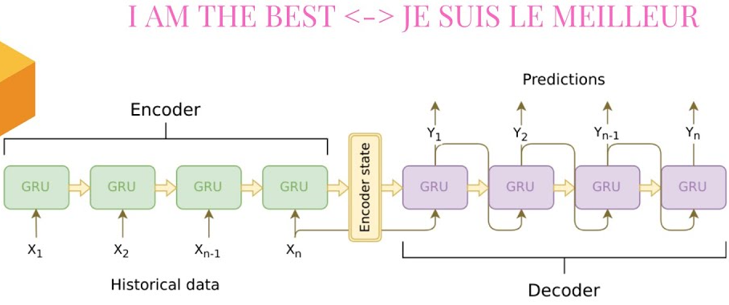

### El *encoder*

Como `encoder` utilizaremos una `red neuronal recurrente` como las que ya hemos utilizado en los posts anteriores. Tendremos una primera capa `embedding` que se encargará de proveer a la `RNN` de la representación vectorial de cada palabra y luego la capa `RNN` (que puede ser también una `LSTM` o `GRU` como ya vimos en este [post](https://sensioai.com/blog/036_rnn_mejoras)). El `encoder` codificará la frase original y nos quedaremos con las salidas de las capas ocultas en el último paso (cuando ya ha visto toda la frase). Este tensor será el responsable de codificar el significado de la frase para que luego el `decoder` pueda traducirla.

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, input_sentences):
        embedded = self.embedding(input_sentences)
        output, hidden = self.gru(embedded)
        # del encoder nos interesa el último *hidden state*
        return hidden

In [ ]:
encoder = Encoder(input_size=input_lang.n_words)
hidden = encoder(torch.randint(0, input_lang.n_words, (16, 10)))

# [num layers, batch size, hidden size]
hidden.shape

torch.Size([2, 16, 100])

### El *decoder*

El `decoder` será de nuevo una `red neuronal recurrente`. A diferencia del `encoder`, el estado oculto del `decoder` lo inicializaremos con el tensor obtenido a la salida del `encoder`. Tanto durante el entrenamiento como en fase de inferencia, le daremos al decoder como primera palabra el token `<sos>`. Con esta información, y el estado oculto del `encoder`, deberá predecir la primera palabra de la frase traducida. Seguidamente, usaremos esta primera palabra como nueva entrada junto al estado oculto obtenido en el paso anterior para generar la segunda palabra. Repetiremos este proceso hasta que el `decoder` nos de el token `<eos>`, indicando que la frase ha terminado.

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.out = torch.nn.Linear(hidden_size, input_size)

    def forward(self, input_words, hidden):
        embedded = self.embedding(input_words)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden
# es una red recurrente
#Entra tambien el idioma al que se va a traducir

In [ ]:
decoder = Decoder(input_size=output_lang.n_words)
output, decoder_hidden = decoder(torch.randint(0, output_lang.n_words, (16, 1)), hidden)

# [batch size, vocab size]
output.shape

torch.Size([16, 38066])

In [ ]:
# [num layers, batch size, hidden size]
decoder_hidden.shape

torch.Size([2, 16, 100])

## Entrenamiento

Vamos a implementar el bucle de entrenamiento. En primer lugar, al tener ahora dos redes neuronales, necesitaremos dos optimizadores (uno para el `encoder` y otro para el `decoder`). Al `encoder` le pasaremos la frase en el idioma original, y obtendremos el estado oculto final. Este estado oculto lo usaremos para inicializar el `decoder` que, junto al token `<sos>`, generará la primera palabra de la frase traducida. Repetiremos el proceso, utilizando como entrada la anterior salida del decoder, hasta obtener el token `<eos>`.

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(encoder, decoder, dataloader, epochs=10):
    encoder.to(device)
    decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_loss = []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            input_sentences, output_sentences = batch
            bs = input_sentences.shape[0]
            loss = 0
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            # obtenemos el último estado oculto del encoder
            hidden = encoder(input_sentences)
            # calculamos las salidas del decoder de manera recurrente
            decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
            for i in range(output_sentences.shape[1]):
                output, hidden = decoder(decoder_input, hidden)
                loss += criterion(output, output_sentences[:, i].view(bs)) #Error criterion
                # el siguiente input será la palbra predicha
                decoder_input = torch.argmax(output, axis=1).view(bs, 1)
            # optimización
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

        val_loss = []
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for batch in bar:
                input_sentences, output_sentences = batch
                bs = input_sentences.shape[0]
                loss = 0
                # obtenemos el último estado oculto del encoder
                hidden = encoder(input_sentences)
                # calculamos las salidas del decoder de manera recurrente
                decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
                for i in range(output_sentences.shape[1]):
                    output, hidden = decoder(decoder_input, hidden)
                    loss += criterion(output, output_sentences[:, i].view(bs))
                    # el siguiente input será la palbra predicha
                    decoder_input = torch.argmax(output, axis=1).view(bs, 1)
                val_loss.append(loss.item())
                bar.set_description(f"Epoch {epoch}/{epochs} val_loss {np.mean(val_loss):.5f}")
    torch.save(encoder.state_dict(),f'/content/drive/MyDrive/exFinal/weights/encoder.pth')
    torch.save(decoder.state_dict(),f'/content/drive/MyDrive/exFinal/weights/decoder.pth')

In [ ]:
fit(encoder, decoder, dataloader, epochs=30)

Epoch 30/30 val_loss 73.04968: 100%|██████████| 430/430 [00:04<00:00, 86.63it/s]


Como puedes ver, la *loss* de enterenamiento baja indicando que nuestra red está aprendiendo a traducir. Sin embargo, la *loss* de validación sube indicando que estamos haciendo *overfitting*. Esto es normal ya que estamos utilizando muy pocos datos para el entrenamiento, para reducir este problema tendrías que utilizar un dataset con más ejemplos.

## Generando traducciones

Una vez tenemos nuestro modelo entrenado, podemos utilizarlo para traducir frases del inglés al castellano de la siguiente manera.

In [ ]:
input_sentence, output_sentence = dataset['test'][112]
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['ahora', 'mi', 'casa', 'esta', 'mas', 'limpia', 'y', 'ordenada', '.', 'EOS'],
 ['kunanqa', 'wasiypas', 'allichasqanam', 'kachkan', '.', 'EOS'])

In [ ]:
print(input_sentence)

tensor([ 936,  156,  587,  199,  233, 3140,   14, 5163,   25,    1],
       device='cuda:0')


In [ ]:
def predict(input_sentence):
    # obtenemos el último estado oculto del encoder
    hidden = encoder(input_sentence.unsqueeze(0))
    # calculamos las salidas del decoder de manera recurrente
    decoder_input = torch.tensor([[output_lang.word2index['SOS']]], device=device)
    # iteramos hasta que el decoder nos de el token <eos>
    outputs = []
    while True:
        output, hidden = decoder(decoder_input, hidden)
        decoder_input = torch.argmax(output, axis=1).view(1, 1)
        outputs.append(decoder_input.cpu().item())
        if decoder_input.item() == output_lang.word2index['EOS']:
            break
    return output_lang.sentenceFromIndex(outputs)

In [ ]:
predict(input_sentence)

['kunanqa',
 'imarayku',
 'imarayku',
 'acuerdopichu',
 'challwa',
 'hinaspa',
 'kichay',
 'nispa',
 '.',
 'EOS']

# Nuevas palabras

In [ ]:
def preprocess_sentence(sentence):
    normalized_sentence = normalizeString(sentence)
    normalized_sentence += " EOS"
    return normalized_sentence

In [ ]:
def sentence_to_indices(sentence, lang):
    return torch.tensor(lang.indexesFromSentence(sentence), device=device, dtype=torch.long).view(1, -1)

In [ ]:
def translate_sentence(sentence, encoder, decoder, input_lang, output_lang):
    # Preprocesamiento
    preprocessed_sentence = preprocess_sentence(sentence)

    # Tokenización
    input_indices = sentence_to_indices(preprocessed_sentence, input_lang)

    # Obtener el estado oculto del encoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        encoder_hidden = encoder(input_indices)

    # Inicializar el decoder con el token SOS
    decoder_input = torch.tensor([[output_lang.word2index['SOS']]], device=device)

    # Traducción secuencial
    translated_words = []
    for _ in range(MAX_LENGTH):  # Evitar bucle infinito
        output, encoder_hidden = decoder(decoder_input, encoder_hidden)
        top_word = torch.argmax(output, dim=1).item()

        if top_word == EOS_token:
            break

        translated_words.append(output_lang.index2word[top_word])

        # Preparar el siguiente input para el decoder
        decoder_input = torch.tensor([[top_word]], device=device)

    translation = ' '.join(translated_words)
    return translation

In [ ]:
new_sentence = "mañana voy a ir a la reunión con todas las ganas"
translation = translate_sentence(new_sentence, encoder, decoder, input_lang, output_lang)
print(f"Input: {new_sentence}\nTranslation: {translation}")

Input: mañana voy a ir a la reunión con todas las ganas
Translation:  rurasqankum hinaspa hinaspa allin qonku paninchikkunataqa


## Obtener weights  para predicciones


In [ ]:
encoder = Encoder(input_size=input_lang.n_words).to(device)
decoder = Decoder(input_size=output_lang.n_words).to(device)

encoder_weights_path = '/content/drive/MyDrive/exFinal/weights/encoder.pth'
decoder_weights_path = '/content/drive/MyDrive/exFinal/weights/decoder.pth'

encoder.load_state_dict(torch.load(encoder_weights_path))
decoder.load_state_dict(torch.load(decoder_weights_path))

<All keys matched successfully>

In [ ]:
encoder.eval()
decoder.eval()

# Función para predecir
def predict(input_sentence, encoder, decoder, output_lang):
    # Obtenemos el último estado oculto del encoder
    hidden = encoder(input_sentence.unsqueeze(0).to(device))

    # Inicializamos el decoder con el token SOS
    decoder_input = torch.tensor([[output_lang.word2index['SOS']]], device=device)

    # Iteramos hasta que el decoder nos de el token <eos>
    outputs = []
    while True:
        output, hidden = decoder(decoder_input, hidden)
        decoder_input = torch.argmax(output, axis=1).view(1, 1).to(device)  # Asegurar que esté en el mismo dispositivo
        outputs.append(decoder_input.cpu().item())
        if decoder_input.item() == output_lang.word2index['EOS']:
            break

    # Convertir los índices predichos a la oración de salida
    translation = output_lang.sentenceFromIndex(outputs)
    return translation

In [ ]:
input_sentence, output_sentence = dataset['test'][6]
predicted_translation = predict(input_sentence, encoder, decoder, output_lang)

In [ ]:
# Mostrar los resultados
print("Input:", input_lang.sentenceFromIndex(input_sentence.tolist()))
print("Actual Output:", output_lang.sentenceFromIndex(output_sentence.tolist()))
print("Predicted Output:", predicted_translation)

Input: ['no', 'olvidemos', 'que', 'si', 'amamos', 'las', 'buenas', 'nuevas', 'nuestros', 'estudiantes', 'lo', 'notaran', '.', 'EOS']
Actual Output: ['chaynaqa', 'amaya', 'qonqasunchu', 'allin', 'noticiata', 'kuyaptinchikqa', 'estudiaqkunapas', 'cuentatam', 'qokunqaku', '.', 'EOS']
Predicted Output: ['amaya', 'niwanchik', 'kapuqniyoq', 'munayqa', 'munayqa', 'munayqa', 'mana', 'imayna', 'kasqanmanta', '.', 'EOS']


In [ ]:
new_sentence = "quiero jugar"
translation = translate_sentence(new_sentence, encoder, decoder, input_lang, output_lang)
print(f"Input: {new_sentence}\nTranslation: {translation}")

Input: quiero jugar
Translation: kusikuykunawan sonqo
